In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
%matplotlib inline

In [59]:
df = pd.read_csv('data.csv')
df

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,46120
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,56670
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50620
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50920


Keep only these columns:

Make,
Model,
Year,
Engine HP,
Engine Cylinders,
Transmission Type,
Vehicle Style,
highway MPG,
city mpg,
MSRP

## Data preparation
- Keep only the columns above
- Lowercase the column names and replace spaces with underscores
- Fill the missing values with 0
- Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1



In [60]:
selected_columns = ['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']
data = df[selected_columns].copy()

data.columns = data.columns.str.replace(' ', '_').str.lower()

data = data.fillna(0)

price_mean = data['msrp'].mean()
data['above_average'] = (data['msrp'] > price_mean).astype(int)

data_copy = data.drop('msrp',axis=1)

data_full_train, data_test = train_test_split(data_copy,test_size=0.2,random_state=1)
data_train, data_val = train_test_split(data_full_train, test_size=0.25, random_state=1)

data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)

y_train = data_train['above_average'].values
y_test = data_test['above_average'].values
y_val = data_val['above_average'].values

del data_train['above_average']
del data_test['above_average']
del data_val['above_average']

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the `above_average` variable
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- engine_hp
- engine_cylinders
- highway_mpg
- city_mpg

In [61]:
numerical = data_train.dtypes[data.dtypes != 'object'].index

for n in numerical:
    auc = roc_auc_score(y_train, data_train[n])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -data_train[n])
    print(n,"--->", round(auc,3))

year ---> 0.688
engine_hp ---> 0.917
engine_cylinders ---> 0.766
highway_mpg ---> 0.633
city_mpg ---> 0.673


_engine_hp_

## Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [62]:
dv = DictVectorizer(sparse=False)

train_dicts = data_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = data_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]

roc_auc_score(y_val,y_pred).round(3)

0.976

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them
At which threshold precision and recall curves intersect?

In [63]:

def confusion_matrix(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0.0,1.0,101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    return pd.DataFrame(scores, columns=columns)

data_score = confusion_matrix(y_val, y_pred)
data_score[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,644,358,10,1371
20,0.2,625,226,29,1503
30,0.3,603,156,51,1573
40,0.4,585,112,69,1617
50,0.5,568,72,86,1657
60,0.6,518,52,136,1677
70,0.7,489,29,165,1700
80,0.8,427,14,227,1715
90,0.9,349,4,305,1725


In [64]:
data_score['P'] = data_score.tp / (data_score.tp+data_score.fp)
data_score['R'] = data_score.tp / (data_score.tp+data_score.fn)

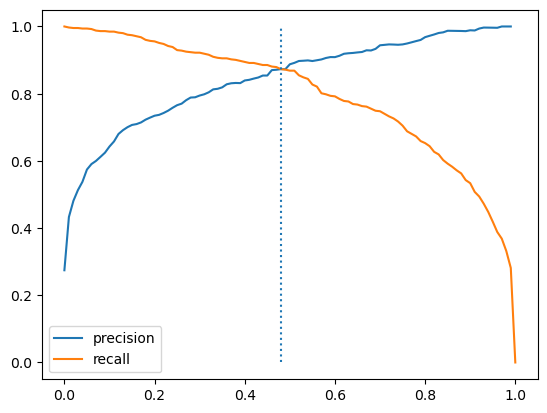

In [73]:
plt.plot(data_score.threshold, data_score.P, label='precision')
plt.plot(data_score.threshold, data_score.R, label='recall')

plt.vlines(0.48, 0, 1, linestyles='dotted')

plt.legend()
plt.show()

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

 F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}  

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [66]:
data_score['f1'] = 2*data_score.P * data_score.R/(data_score.P+data_score.R)
max(data_score['f1'])

0.8799380325329201

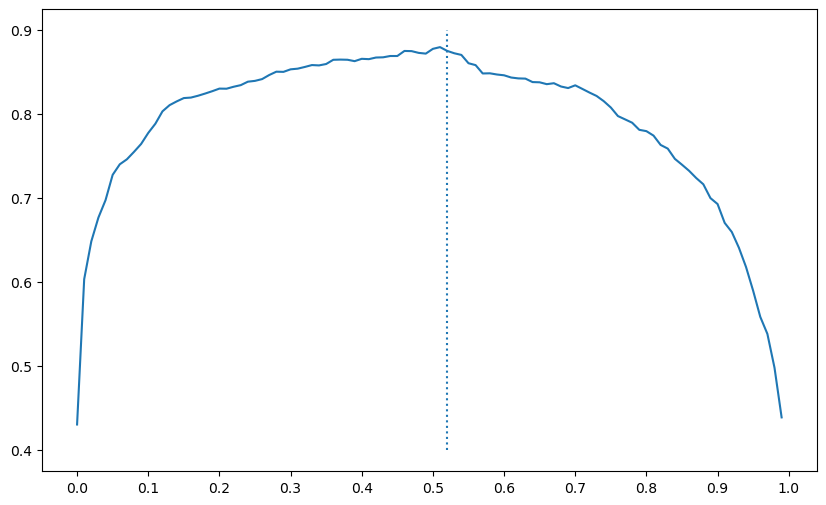

In [80]:
plt.figure(figsize=(10,6))
plt.plot(data_score.threshold, data_score.f1)
plt.vlines(0.52, 0.4, 0.9, linestyle='dotted')
plt.xticks(np.linspace(0.0, 1.0, 11))

plt.show()

## Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [68]:
columns=list(data_full_train.columns)
columns.remove('above_average')
columns

['make',
 'model',
 'year',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg']

In [69]:
def train(data_train, y_train, C=1.0):
    dicts = data_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(data, dv, model):
    dicts = data[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    return model.predict_proba(X)[:, 1]

In [70]:
kfold = KFold(n_splits=5,shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(data_full_train):
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]

    y_train = data_train['above_average'].values
    y_val = data_val['above_average'].values

    dv, model = train(data_train, y_train, C=1.0)
    y_pred = predict(data_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))


0.980 +- 0.003


## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 0.5, 10]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [71]:
kfold = KFold(n_splits=5,shuffle=True, random_state=1)
for c in [0.01, 0.1, 0.5, 10]:

    scores = []

    for train_idx, val_idx in kfold.split(data_full_train):
        data_train = data_full_train.iloc[train_idx]
        data_val = data_full_train.iloc[val_idx]

        y_train = data_train['above_average'].values
        y_val = data_val['above_average'].values

        dv, model = train(data_train, y_train, C=c)
        y_pred = predict(data_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('%3s  %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))


0.01  0.952 +- 0.002
0.1  0.972 +- 0.002
0.5  0.978 +- 0.001
 10  0.982 +- 0.003
